In [1]:
# Cell 1: Import necessary libraries
import os
import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [2]:
# Cell 2: Check OpenCV version and Haar Cascade file
print("OpenCV version:", cv2.__version__)

haarcascade_path = cv2.data.haarcascades
face_cascade_path = os.path.join(haarcascade_path, 'haarcascade_frontalface_default.xml')

if os.path.exists(face_cascade_path):
    print("Haar Cascade file found:", face_cascade_path)
else:
    print("Haar Cascade file not found!")

OpenCV version: 4.10.0
Haar Cascade file found: C:\Users\User\anaconda3\envs\tensorflowEnv_20240417\lib\site-packages\cv2\data\haarcascade_frontalface_default.xml


In [3]:
# Cell 3: Define parameters
num_features = 64
batch_size = 64
epochs = 30
width, height = 48, 48

train_directory = 'E:/p2/archive/train'
test_directory = 'E:/p2/archive/test'

In [4]:
# Cell 4: Define ImageDataGenerator for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

print("Classes:", train_generator.class_indices)
num_labels = len(train_generator.class_indices)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Classes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# Cell 5: Check class distribution
class_counts_train = train_generator.classes
unique_train, counts_train = np.unique(class_counts_train, return_counts=True)
print("Training set class distribution:", dict(zip(unique_train, counts_train)))

class_counts_val = validation_generator.classes
unique_val, counts_val = np.unique(class_counts_val, return_counts=True)
print("Validation set class distribution:", dict(zip(unique_val, counts_val)))

class_counts_test = test_generator.classes
unique_test, counts_test = np.unique(class_counts_test, return_counts=True)
print("Test set class distribution:", dict(zip(unique_test, counts_test)))


Training set class distribution: {0: 3196, 1: 349, 2: 3278, 3: 5772, 4: 3972, 5: 3864, 6: 2537}
Validation set class distribution: {0: 799, 1: 87, 2: 819, 3: 1443, 4: 993, 5: 966, 6: 634}
Test set class distribution: {0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1233, 5: 1247, 6: 831}


In [7]:
# Cell 6: Design the CNN model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation='softmax'))


In [8]:
# Cell 7: Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [9]:
# Cell 8: Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [10]:
# Cell 9: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/30
358/358 [==============================] - 610s 2s/step - loss: 1.7920 - accuracy: 0.2854 - val_loss: 1.7711 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 2/30
358/358 [==============================] - 476s 1s/step - loss: 1.5334 - accuracy: 0.3998 - val_loss: 1.5138 - val_accuracy: 0.3943 - lr: 0.0010
Epoch 3/30
358/358 [==============================] - 476s 1s/step - loss: 1.3801 - accuracy: 0.4669 - val_loss: 1.3275 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 4/30
358/358 [==============================] - 471s 1s/step - loss: 1.3095 - accuracy: 0.4975 - val_loss: 1.4315 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 5/30
358/358 [==============================] - 211s 588ms/step - loss: 1.2448 - accuracy: 0.5274 - val_loss: 1.4060 - val_accuracy: 0.4566 - lr: 0.0010
Epoch 6/30
358/358 [==============================] - 87s 242ms/step - loss: 1.1882 - accuracy: 0.5511 - val_loss: 1.1857 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 7/30
358/358 [==============================] - 83s 2

In [11]:
# Cell 10: Save the model
model_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("fer.h5")

In [12]:
# Cell 11: Evaluate the model
train_score = model.evaluate(train_generator, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100 * train_score[1])
val_score = model.evaluate(validation_generator, verbose=0)
print('Validation loss:', val_score[0])
print('Validation accuracy:', 100 * val_score[1])
test_score = model.evaluate(test_generator, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100 * test_score[1])


Train loss: 0.5762666463851929
Train accuracy: 79.976487159729
Validation loss: 1.1436418294906616
Validation accuracy: 59.101200103759766
Test loss: 1.1346546411514282
Test accuracy: 59.765952825546265


In [13]:
# Cell 12: Get predictions and true labels
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes[:len(y_pred)]


90/90 [==============================] - 8s 81ms/step


In [14]:
# Cell 13: Print classification report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))


              precision    recall  f1-score   support

       angry       0.53      0.44      0.48       799
     disgust       0.79      0.39      0.52        87
        fear       0.45      0.32      0.38       819
       happy       0.78      0.81      0.80      1443
     neutral       0.52      0.58      0.55       993
         sad       0.45      0.53      0.49       966
    surprise       0.68      0.76      0.72       634

    accuracy                           0.59      5741
   macro avg       0.60      0.55      0.56      5741
weighted avg       0.59      0.59      0.59      5741



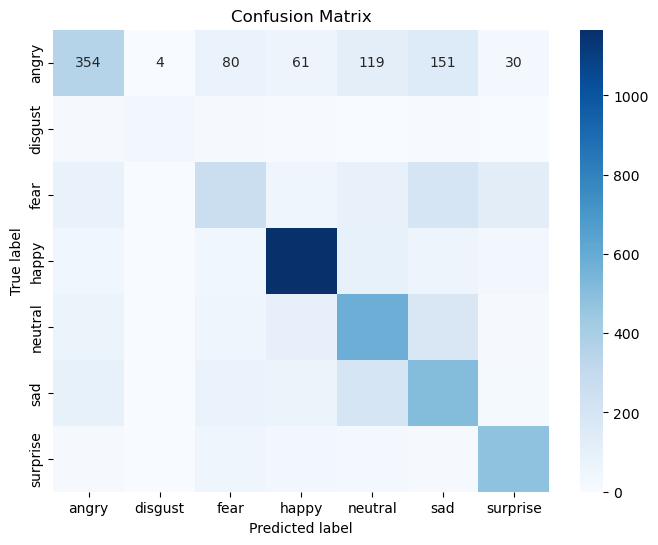

In [15]:
# Cell 14: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [16]:
# Cell 15: Load the saved model for real-time emotion recognition
model = model_from_json(open("fer.json", "r").read())
model.load_weights('fer.h5')

face_haar_cascade = cv2.CascadeClassifier(face_cascade_path)

cap = cv2.VideoCapture(0)

while True:
    ret, test_img = cap.read()
    if not ret:
        print("Error: Unable to capture frame from the webcam.")
        break

    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=7)
        roi_gray = gray_img[y:y + w, x:x + h]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        img_pixels = img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis', resized_img)

    if cv2.waitKey(10) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step
